# Еще раз пытаемся построить RNN

In [2]:
import pandas as pd
import numpy as np
import torch

from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm.notebook import tqdm
from jacobi import DatasetGenerator

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.4)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Сжатие с помощью PCA

Постановка эксепримента:

Делаем следующее: снижаем размерность с помощью PCA. Дальше надеемся, что на первых 1000 шагах сеть выучит, какое преобразование связывает преобразование картинки на каждом шаге алгоритма Якоби в низкоразмерном прстранстве и сможет продолжить некоторое количество шагов вперед.

In [0]:
dg = DatasetGenerator(100)
dg(num_sample=1, batch_size=1, print_every=1, save=True,
   dir='/content/drive/My Drive/NN_PDE_SPEEDUP/Jacobi_data/full_history')

In [0]:
data = next(DatasetGenerator(100).load(
    dir="/content/drive/My Drive/NN_PDE_SPEEDUP/Jacobi_data/full_history",
    load_history=True
    ))

In [4]:
data['history'].shape

(1, 10000, 101, 101)

In [0]:
decomposer = PCA(n_components=40)
decomposer.fit(data['history'][0][:5000].reshape(-1, 101 * 101))
X_transformed = decomposer.transform(data['history'].reshape(-1, 101 * 101))

Сравним качество восстановления:

In [6]:
last_vector = X_transformed[-1:, :]
last_image = decomposer.inverse_transform(last_vector).reshape(1, 101, 101)
last_dump = data['history'][:, -1, :, :]
print('Невязка:')
np.max(np.abs(last_dump - last_image)) / np.max(np.abs(last_dump))

Невязка:


1.819024891257824e-07

В рамках одной задачи допустимо сжатие до 40 компонент. Т.е. траектория метода Якоби лежит в малоразмерном пространстве (напомним, что сам вектор лежит в пространстве размерности 101 * 101).

In [0]:
history = data['history'][0].reshape(-1, 101 * 101)

history_trsmd = decomposer.transform(history)

train_index = 3000
X_train = history_trsmd[:train_index].reshape(100, -1, 40)
X_test = history_trsmd[train_index:].reshape(-1, 1, 40)

Построим модель:

In [0]:
class OneStepModel(nn.Module):

    def __init__(self, hidden_size):
        super().__init__()
        self.rnn = nn.LSTM(40, hidden_size)
        self.decoder = nn.Linear(hidden_size, 40)

    def forward(self, seq, hidden=None):
        output, last_hidden = self.rnn(seq, hidden)
        x = self.decoder(output)
        return x, last_hidden

In [0]:
model = OneStepModel(500)
model = model.float()

Зададим основные конфигурации обучения:

In [0]:
num_epochs = 1000
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

Переведем данные в тензоры PyTorch.

In [0]:
X_train = torch.from_numpy(X_train).float().transpose(1, 0)
X_test = torch.from_numpy(X_test).float()
loss_train = []
loss_test = []


In [12]:
model.cuda()
X_train = X_train.cuda()
X_test = X_test.cuda()

for epoch in tqdm(range(num_epochs)):
    model.train()
    scores, last_hidden = model(X_train[:-1])
    loss = criterion(scores, X_train[1:])
    loss_train.append(loss.item())
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    test_scores, _ = model(X_test[:-1])
    loss = criterion(test_scores, X_test[1:])
    loss_test.append(loss.item())

Псмотрим на графики обучения:

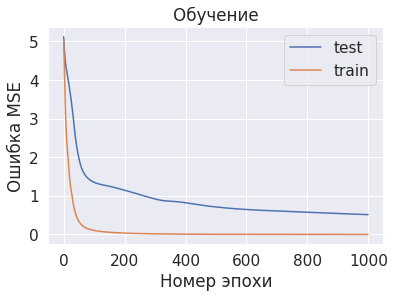

In [13]:
plt.plot(loss_test, label='test')
plt.plot(loss_train, label='train')
plt.legend()
plt.xlabel('Номер эпохи')
plt.ylabel('Ошибка MSE')

plt.title('Обучение')
plt.show()

Ниже прелдставлен график падения точности. В данном случае используется не совсем неувязка. Чтобы проверить качество работы алгоритма, рассчитывается слудедующая величина:

$$
LSTMtol = \frac{\max|LSTMstep[i] - StatSolution|}{\max |StatSolution|},
$$

где $LSTMstep[i]$ --- предсказание LSTM на шаге $i$, $StatSolution$ --- стационарное решение задачи методом Якоби. Обычную невязку мы здесь не использовали т.к., как мы позже увидим, неподвижная точка нейронной сетки не является стационарным состоянием.

In [20]:
output, hidden = model(X_train.reshape(-1, 1, 40))
lstm_tol = []
jacobi_tol = []

for i in range(train_index, 10000):
    output, hidden = model(output[-1:], hidden)
    current_output = output[0].cpu().detach().numpy()
    current_output = decomposer.inverse_transform(current_output)

    lstm_tol.append(
        np.max(np.abs(current_output[0] - history[-1])) /
        np.max(np.abs(history[-1]))
    )

    jacobi_tol.append(
        np.max(np.abs(history[-1] - history[i])) /
        np.max(np.abs(history[-1]))
    )
result = output[0].cpu().detach().numpy()
result = decomposer.inverse_transform(result)
result.shape

(1, 10201)

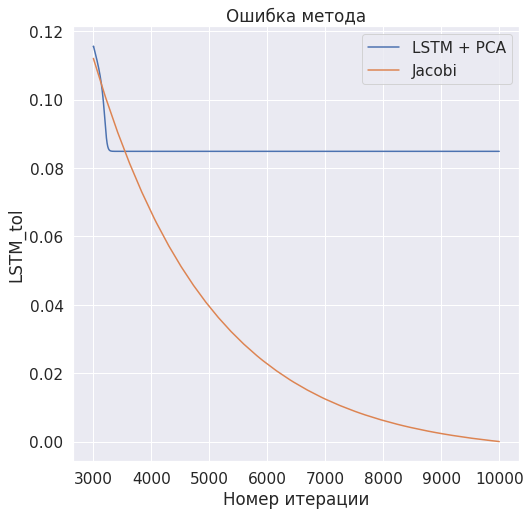

In [21]:
plt.figure(figsize=(8, 8))

plt.plot(np.arange(train_index, 10000), lstm_tol, label='LSTM + PCA')
plt.plot(np.arange(train_index, 10000), jacobi_tol, label='Jacobi')

plt.xlabel('Номер итерации')
plt.ylabel('LSTM_tol')
plt.title('Ошибка метода')
plt.legend()
plt.show()

Посмотрим на то, как метод продолжит траекторию до финальной точки:

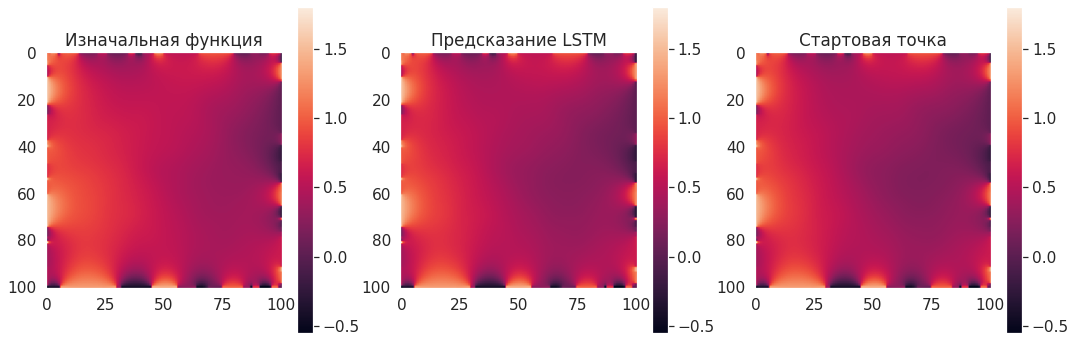

In [18]:
fig = plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
im = plt.imshow(history[-1].reshape(101, 101))
plt.colorbar(im)
plt.grid(False)
plt.title('Изначальная функция')

plt.subplot(1, 3, 2)
im = plt.imshow(result.reshape(101, 101))
plt.colorbar(im)
plt.grid(False)
plt.title('Предсказание LSTM')

plt.subplot(1, 3, 3)
im = plt.imshow(history[train_index].reshape(101, 101))
plt.colorbar(im)
plt.grid(False)
plt.title('Стартовая точка')
plt.show()

In [17]:
print(f'''LSTM_tol предсказания
{np.max(np.abs(result - history[-1])) / np.max(np.abs(history[-1]))}
''')

print(f'''LSTM_tol стартовой точки:
{np.max(np.abs(history[train_index] - history[-1])) / np.max(np.abs(history[-1]))}
''')

LSTM_tol предсказания
0.08487487240211437

LSTM_tol стартовой точки:
0.11205143666848642



Кртакий вывод: стоит заметить, что в конце концов сеть выходит на фиксированнную невязку, полсе чего ничего уже не делает. Т.е. в качестве имитации алгоритма Якоби она работает ограниченное количество времени. Возможно, что дело в очень малой выборке. Загрузим давно сгенерированный нами датасет.

## PCA + RNN

Загрузим данные:

In [0]:
data = next(DatasetGenerator(-1).load(
    dir="/content/drive/My Drive/NN_PDE_SPEEDUP/Jacobi_data",
    load_history=True
))['history']

Научимся сжимать данные:

In [0]:
arxivizer = PCA(n_components=1000)
train_data = data[:750]
test_data = data[750:]

arxivizer.fit(
    data[:250].reshape(-1, 101 * 101)
)

PCA(copy=True, iterated_power='auto', n_components=1000, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Теперь подготовим выборку для нашего датасета:

In [0]:
X_train = arxivizer.transform(
    train_data.reshape(-1, 101 * 101)
).reshape(750, 100, -1)

X_test = arxivizer.transform(
    test_data.reshape(-1, 101 * 101)
).reshape(250, 100, -1)

del data

Предсатвим модель. Она сжиамет данные до 500, после обучается на LSTM.

In [0]:
class LSTM_step_predictor(nn.Module):

    def __init__(self, hidden_size, reduce_to):
        super().__init__()
        self.encoder = nn.Linear(1000, reduce_to)
        self.relu = nn.ReLU()
        self.rnn = nn.LSTM(reduce_to, hidden_size, num_layers=3)
        self.decoder_1 = nn.Linear(hidden_size, reduce_to)
        self.decoder_2 = nn.Linear(reduce_to, 1000)

    def forward(self, seq, hidden=None):
        x = self.encoder(seq)
        x = self.relu(x)
        output, last_hidden = self.rnn(x, hidden)
        x = self.decoder_1(output)
        x = self.relu(x)
        x = self.decoder_2(x)
        return x, last_hidden

In [0]:
model = LSTM_step_predictor(500, 500)
model = model.float()
model.cuda()

LSTM_step_predictor(
  (encoder): Linear(in_features=1000, out_features=100, bias=True)
  (relu): ReLU()
  (rnn): LSTM(100, 500, num_layers=3)
  (decoder_1): Linear(in_features=500, out_features=100, bias=True)
  (decoder_2): Linear(in_features=100, out_features=1000, bias=True)
)

In [0]:
test_data = torch.from_numpy(X_test).transpose(0, 1).cuda()

In [0]:
data_loader = DataLoader(X_train, batch_size=50)
num_epochs = 100
criterion = nn.MSELoss()
loss_test = []

In [0]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
for epoch in tqdm(range(num_epochs)):
    model.train()
    for batch in data_loader:
        batch = batch.transpose(0, 1)
        batch = batch.float()
        batch = batch.cuda()

        scores, _ = model(batch[:-1])
        loss = criterion(scores, batch[1:])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    model.eval()
    scores, _ = model(test_data[:-1].float())
    loss = criterion(scores, test_data[1:])
    loss_test.append(np.log(loss.item()))


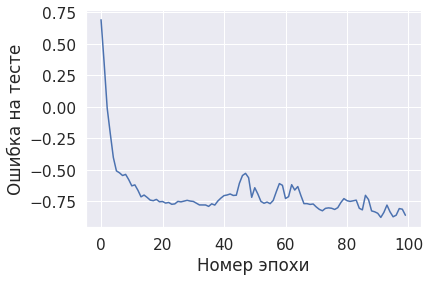

In [0]:
plt.plot(loss_test)
plt.xlabel('Номер эпохи')
plt.ylabel('Ошибка на тесте')
plt.show()

Заметим, что GRU дет чуть меньшую ошибку, чем LSTM, но очень незначительную. Посмотрим, как хорошо аппроксимирует происходящее сеть. Для этого рассмотрим эволюцию системы на произвольном тестовом решении.

In [0]:
test = next(DatasetGenerator(-1).load(
    dir="/content/drive/My Drive/NN_PDE_SPEEDUP/Jacobi_data/test",
    load_history=True
))['history']

test.shape

(1, 100, 101, 101)

In [0]:
transformed_test = arxivizer.transform(test[0].reshape(-1, 101 * 101))
transformed_test.shape

(100, 1000)

In [0]:
start_index = 1
start_point = transformed_test[:start_index].reshape(start_index, 1, 1000)
output, hidden = model(torch.from_numpy(start_point).float().cuda())
answers = []
for i in range(start_index, 100):
    output, hidden = model(output[-1:], hidden)
    answers.append(
        arxivizer.inverse_transform(
            output[-1].cpu().detach().numpy()
            ).reshape(101, 101)
    )
len(answers)

99

In [0]:
answers = list(test[0, :start_index]) + answers 

In [0]:
from ipywidgets import interact
import ipywidgets as widgets

ОБозначенная тут невязка также в действительности является величиной LSTMtol из предыдущего пункта.

In [0]:
def plt_imshow(index):

    print('Невязка:',
        np.max(np.abs(test[0, -1] - answers[index]))/
        np.max(np.abs(test[0, -1]))
    )

    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    im = plt.imshow(test[0, index], vmin=-2, vmax=2)
    plt.colorbar(im)
    plt.grid(False)
    plt.title(f'Изначальная функция {index}')

    plt.subplot(1, 2, 2)
    im = plt.imshow(answers[index],  vmin=-2, vmax=2)
    plt.colorbar(im)
    plt.grid(False)
    plt.title(f'Предсказание LSTM {index}')
    plt.show()

In [0]:
interact(plt_imshow, index=(0, 99, 1));

interactive(children=(IntSlider(value=49, description='index', max=99), Output()), _dom_classes=('widget-inter…

Анимированный результат можно посмотреть в папке `img` на GitHub под названием `lstm_1.gif`.

## Автоэнкодер + RNN (Автоэнкодер построен неверно, его не получилось обучить)

In [0]:
data = next(DatasetGenerator(-1).load(
    dir="/content/drive/My Drive/NN_PDE_SPEEDUP/Jacobi_data",
    load_history=True
))['history']
data.shape

(1000, 100, 101, 101)

In [0]:
class DenseLayer(nn.Module):

    def __init__(self, in_channels):
        super().__init__()
     
        self.conv_1_1 = nn.Conv2d(in_channels, 5, kernel_size=3, padding=1)
        self.conv_2_1 = nn.Conv2d(in_channels, 5, kernel_size=5, padding=2)
        self.conv_3_1 = nn.Conv2d(in_channels, 5, kernel_size=7, padding=3)
        self.conv_4_1 = nn.Conv2d(in_channels, 5, kernel_size=9, padding=4)
        self.batch_norm_1 = nn.BatchNorm2d(20)

        self.conv_1_2 = nn.Conv2d(20, 5, kernel_size=3, padding=1)
        self.conv_2_2 = nn.Conv2d(20, 5, kernel_size=5, padding=2)
        self.conv_3_2 = nn.Conv2d(20, 5, kernel_size=7, padding=3)
        self.conv_4_2 = nn.Conv2d(20, 5, kernel_size=9, padding=4)
        self.batch_norm_2 = nn.BatchNorm2d(20)

        self.conv_1_3 = nn.Conv2d(20, 5, kernel_size=3, padding=1)
        self.conv_2_3 = nn.Conv2d(20, 5, kernel_size=5, padding=2)
        self.conv_3_3 = nn.Conv2d(20, 5, kernel_size=7, padding=3)
        self.conv_4_3 = nn.Conv2d(20, 5, kernel_size=9, padding=4)
        self.batch_norm_3 = nn.BatchNorm2d(20)

        self.conv_1_4 = nn.Conv2d(20, 5, kernel_size=3, padding=1)
        self.conv_2_4 = nn.Conv2d(20, 5, kernel_size=5, padding=2)
        self.conv_3_4 = nn.Conv2d(20, 5, kernel_size=7, padding=3)
        self.conv_4_4 = nn.Conv2d(20, 5, kernel_size=9, padding=4)
        self.batch_norm_4 = nn.BatchNorm2d(20)

        self.max_pooling = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()


    def forward(self, x):

        output_1 = torch.cat((
            self.conv_1_1(x),
            self.conv_2_1(x),
            self.conv_3_1(x),
            self.conv_4_1(x)
        ), dim=1)

        output_1 = self.batch_norm_1(output_1)
        output_1 = self.relu(output_1)

        output_2 = torch.cat((
            self.conv_1_2(output_1 + x),
            self.conv_2_2(output_1 + x),
            self.conv_3_2(output_1 + x),
            self.conv_4_2(output_1 + x)
        ), dim=1)

        output_2 = self.batch_norm_2(output_2)
        output_2 = self.relu(output_2)

        output_3 = torch.cat((
            self.conv_1_3(output_2 + output_1 + x),
            self.conv_2_3(output_2 + output_1 + x),
            self.conv_3_3(output_2 + output_1 + x),
            self.conv_4_3(output_2 + output_1 + x)
        ), dim=1)

        output_3 = self.batch_norm_3(output_3)
        output_3 = self.relu(output_3)

        output_4 = torch.cat((
            self.conv_1_4(output_3 + output_2 + output_1 + x),
            self.conv_2_4(output_3 + output_2 + output_1 + x),
            self.conv_3_4(output_3 + output_2 + output_1 + x),
            self.conv_4_4(output_3 + output_2 + output_1 + x)
        ), dim=1)

        output_4 = self.batch_norm_4(output_4)
        output_4 = self.relu(output_4)

        x = self.max_pooling(output_4)
        return x

class DenseLayerTranspose(nn.Module):

    def __init__(self, pool, stride):
        super().__init__()

        self.convT_1_1 = nn.ConvTranspose2d(20, 5, 
                                            kernel_size=3,
                                            padding=1)
        self.convT_2_1 = nn.ConvTranspose2d(20, 5, 
                                            kernel_size=5,
                                            padding=2)
        self.convT_3_1 = nn.ConvTranspose2d(20, 5, 
                                            kernel_size=7,
                                            padding=3)
        self.convT_4_1 = nn.ConvTranspose2d(20, 5,
                                            kernel_size=9,
                                            padding=4)

        self.batch_norm_1 = nn.BatchNorm2d(20)

        self.convT_1_2 = nn.ConvTranspose2d(20, 5, 
                                            kernel_size=3,
                                            padding=1)
        self.convT_2_2 = nn.ConvTranspose2d(20, 5, 
                                            kernel_size=5,
                                            padding=2)
        self.convT_3_2 = nn.ConvTranspose2d(20, 5,
                                            kernel_size=7,
                                            padding=3)
        self.convT_4_2 = nn.ConvTranspose2d(20, 5, 
                                            kernel_size=9,
                                            padding=4)

        self.batch_norm_2 = nn.BatchNorm2d(20)

        self.convT_1_3 = nn.ConvTranspose2d(20, 5, 
                                            kernel_size=3,
                                            padding=1)
        self.convT_2_3 = nn.ConvTranspose2d(20, 5, 
                                            kernel_size=5,
                                            padding=2)
        self.convT_3_3 = nn.ConvTranspose2d(20, 5,
                                            kernel_size=7,
                                            padding=3)
        self.convT_4_3 = nn.ConvTranspose2d(20, 5,
                                            kernel_size=9,
                                            padding=4)
        
        self.batch_norm_3 = nn.BatchNorm2d(20)
        
        self.convT_1_4 = nn.ConvTranspose2d(20, 5,
                                            kernel_size=3,
                                            padding=1,
                                            stride=stride)
        self.convT_2_4 = nn.ConvTranspose2d(20, 5,
                                            kernel_size=5,
                                            padding=2,
                                            stride=stride)
        self.convT_3_4 = nn.ConvTranspose2d(20, 5,
                                            kernel_size=7,
                                            padding=3,
                                            stride=stride)
        self.convT_4_4 = nn.ConvTranspose2d(20, 5,
                                            kernel_size=9,
                                            padding=4,
                                            stride=stride)
        
        self.batch_norm_4 = nn.BatchNorm2d(20)

        self.relu = nn.ReLU()
        self.pool = pool

    def forward(self, x):
        
        input_1 = torch.cat((
            self.convT_1_1(x),
            self.convT_2_1(x),
            self.convT_3_1(x),
            self.convT_4_1(x)
        ), dim=1)

        input_1 = self.batch_norm_1(input_1)
        input_1 = self.relu(input_1)

        input_2 = torch.cat((
            self.convT_1_2(x + input_1),
            self.convT_2_2(x + input_1),
            self.convT_3_2(x + input_1),
            self.convT_4_2(x + input_1)
        ), dim=1)

        input_2 = self.batch_norm_2(input_2)
        input_2 = self.relu(input_2)

        input_3 = torch.cat((
            self.convT_1_3(x + input_1 + input_2),
            self.convT_2_3(x + input_1 + input_2),
            self.convT_3_3(x + input_1 + input_2),
            self.convT_4_3(x + input_1 + input_2)
        ), dim=1)

        input_3 = self.batch_norm_3(input_3)
        input_3 = self.relu(input_3)

        input_4 = torch.cat((
            self.convT_1_4(x + input_1 + input_2 + input_3),
            self.convT_2_4(x + input_1 + input_2 + input_3),
            self.convT_3_4(x + input_1 + input_2 + input_3),
            self.convT_4_4(x + input_1 + input_2 + input_3)
        ), dim=1)

        input_4 = self.batch_norm_4(input_4)
        input_4 = self.relu(input_4)
        
        return input_4



In [0]:
class Encoder(nn.Module):

    def __init__(self):
        super().__init__()
        self.dense_1 = DenseLayer(1)
        self.dense_2 = DenseLayer(20)
        self.dense_3 = DenseLayer(20)
        self.dense_4 = DenseLayer(20)

    def forward(self, x):
        x = self.dense_1(x)
        x = self.dense_2(x)
        x = self.dense_3(x)
        x = self.dense_4(x)
        return x

class Decoder(nn.Module):

    def __init__(self):
        super().__init__()
        self.denseT_1 = DenseLayerTranspose(False, 3)
        self.denseT_2 = DenseLayerTranspose(False, 2)
        self.denseT_3 = DenseLayerTranspose(False, 2)
        self.denseT_4 = DenseLayerTranspose(True, 2)
        self.conv_last = nn.Conv2d(20, 1, 21)

    def forward(self, x):
        x = self.denseT_1(x)
        x = self.denseT_2(x)
        x = self.denseT_3(x)
        x = self.denseT_4(x)
        x = self.conv_last(x)
        return x
        

Сначала проверим работу автоэнкодера:

In [0]:
class Autoencoder(nn.Module):

    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [0]:
model = Autoencoder()
model = model.double()
model.cuda()

Autoencoder(
  (encoder): Encoder(
    (dense_1): DenseLayer(
      (conv_1_1): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_2_1): Conv2d(1, 5, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (conv_3_1): Conv2d(1, 5, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (conv_4_1): Conv2d(1, 5, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
      (batch_norm_1): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_1_2): Conv2d(20, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_2_2): Conv2d(20, 5, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (conv_3_2): Conv2d(20, 5, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (conv_4_2): Conv2d(20, 5, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
      (batch_norm_2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_1_3): Conv2d(20, 5, kernel_size=(3, 3), stride=(1, 1), padding

In [0]:
class Dataset():

    def __init__(self, history_data):
        self.data = history_data

    def __getitem__(self, index):
        result = self.data[index // 100, index % 100]
        result = torch.tensor(result, dtype=torch.double).cuda()
        result = result.view(1, *result.shape)
        return result

    def __len__(self):
        return len(self.data) * 100

In [0]:
train_data = Dataset(data[:900])
test_data = Dataset(data[900:])
train_data[0].shape

torch.Size([1, 101, 101])

In [0]:
train_loader = DataLoader(train_data, batch_size=50)
test_loader = DataLoader(test_data, batch_size=50)
for batch in train_loader:
    print(batch.shape)
    break

torch.Size([50, 1, 101, 101])


In [0]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 5
test_loss = []

model.load_state_dict(torch.load(
    "/content/drive/My Drive/NN_PDE_SPEEDUP/Autoencoder/autoencoder.model"
    ))

<All keys matched successfully>

In [0]:
for epoch in tqdm(range(1)):
    model.train()
    for batch in tqdm(train_loader):
        scores = model(batch)

        loss = criterion(scores, batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    torch.save(model.state_dict(), 
    "/content/drive/My Drive/NN_PDE_SPEEDUP/Autoencoder/autoencoder.model"
    )


In [0]:
model.eval()
loss = 0
for batch in tqdm(test_loader):
        scores = model(batch)
        loss += criterion(scores, batch).item()
loss / len(test_loader)

25.788325236595206

In [0]:
input_data = test_data[99]
scores = model(input_data.view(1, *input_data.shape))
torch.max(torch.abs(scores[0] - input_data)) / torch.max(torch.abs(input_data))

tensor(1.0071, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)

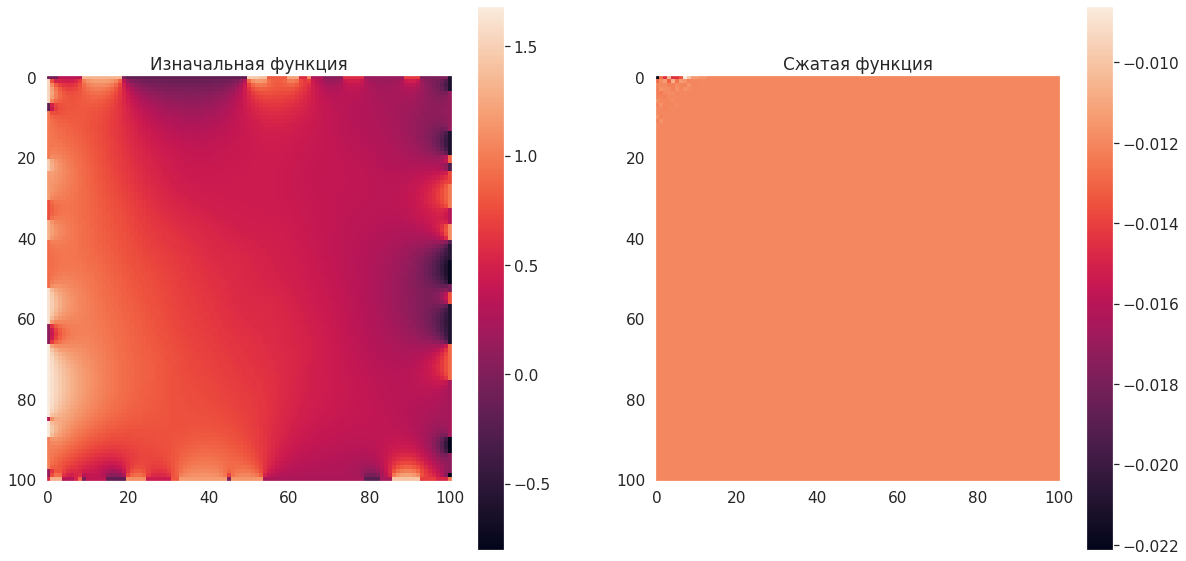

In [0]:
fig = plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
im = plt.imshow(input_data[0].detach().cpu().numpy())
plt.colorbar(im)
plt.grid(False)
plt.title('Изначальная функция')

plt.subplot(1, 2, 2)
im = plt.imshow(scores[0, 0].detach().cpu().numpy())
plt.colorbar(im)
plt.grid(False)
plt.title('Сжатая функция')
plt.show()

# Еще один подход: попробуем с помощью нелинейной функции ускорить процесс сходимости алгоритма Якоби

Мы пытаемся с помощью некоего существенно нелинейного преобразования ускорить сеть. Важно понять, за счет чего это можно сделать. Обратим внимание, что сверточная сеть подходит мало: она работает на преобразование фрагмента изображения и долго передает внутри себя информацию от одного окна к другому. 

Посмотрим, что будет, если мы попытаемся снизить размерность с помощью PCA. Может ли, хотя бы в теории, использование нелинейного преобразования (т.е. не аппроксимация степени матрицы Якоби) ускорить нашу сходимость. 

Пусть $n = N^2$ --- размер нашего изображения. За один шаг совершается $4 N^2$ операций. Если мы хотим снизить размерность, то делается это умножением матрицы. Стоимость перемножения матрицы на вектор --- $d \cdot N^2$, где мы умножаем на матрицу из PCA. Таким образом, снижение размерность обходиться в $d / 4$ операций алгоритма Якоби. Учитывая обратное преобразование, только на снижение размерности мы затрачиваем $d / 2$ итераций алгоритма Якоби. В нашем случае $d = 1000$, а всего итераций алгоритма --- $10000^2 = 10^{8}$.

Предположим, что мы приближаем двухслойной сетью. Пусть размер скрутого слоя --- $H$. Тогда сеть осуществляет $2 H d$ операций.

Еще замечание. Пусть $E$ --- матрица PCA. Тогда домножим обе части итерации алгоритма Якоби на $E$:

$$
E u' = E (Tu - \frac{h^2}{4} f) = E T E^T (E u) - \frac{h^2}{4} Ef
$$

Запишем происходящее в нотации Эйнштейна:

$$
(E T E^T)_{lk} = (ET)_{lpq} E_{k pq} = E_{lij} T_{ijpq} E_{kpq}
$$

$$
T_{ij pq} = \frac{1}{4} (\delta_{i p + 1} \delta_{j q} + \delta_{ip-1} \delta_{jq} + \delta_{i p} \delta_{j q+1} + \delta_{i p} \delta_{j q-1}) I\{i \in [1, n-2], j \in [1, n-2]\} + I\{i \in \{0, n-1\} \text{ or } j \in \{0, n-1\} \} \delta_{ip} \delta_{jq}
$$

Распишем, что такое  $E_{lij} \delta_{i p + 1} \delta_{j q} E_{kpq}I\{i \in [1, n-2], j \in [1, n-2]\} $:

$$
E_{lij} \delta_{i p + 1} \delta_{j q} E_{kpq} = E_{lp+1 q} E_{kpq} I\{p \in [0, n-3], q \in [1, n-2]\}.
$$

Далее обратим внимание, что трехмерному тензору $E_{kpq}$, действующему на $u_{pq}$ соответствует матрица $E_{k (Np + q)}$, которая уже работает с $u_{Np + q}$. Тогда $E_{lp+1 q} E_{kpq} = E_{k (s + N)} E_{ls}$. В конечном итоге мы хотим найти степень преобразования:

$$
\frac{1}{4} \left (E_{k (s + N)} E_{ls} + E_{k (s - N)} E_{ls} + E_{k (s +1)}E_{ls} + E_{k (s-1)} E_{ls} \right) - \frac{h^2}{4} E f.
$$

Индикаторы, чтобы не загромождать формулами лист, опущены. Таким образом, сжимаемость с помощью PCA означает возможность совершения в алгоритме Якоби вместо $N^6$ операций $2 dN^2 + N^4 d^2 \approx N^4 d^2$ операций. Заметим, однако, что это бессмысленно: в действительности количество операций возрасло в нашем случае в 10 раз, т.к. мы перешли к плотному преобразованию, требующему $d^2$ операций, в то время как преобразование в пространстве размерности $N^2$ требовало всего лишь $O(N^2)$ операций.

Обозначим за $F$ скобку в полученном нами уравнении. Пусть мы совершили $r$ итераций в малоразмрном пространстве. Тогда итоговое преобразование имеет вид:

$$
F^r - \frac{h^2}{4} \sum_{i=1}^r Ef 
$$

Такое преобразование может быть предпосчитано (потому что матрица $F$ имеет размерность $d \times d$). Более того, кажется, это можно сделать быстрее, чем обучить нейросеть.